# SV-RCNet

In [1]:
# imports
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from PIL import Image
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from utils.clean_labels import clean_labels
from utils.build_dataset import SVRCDataset

import os
from datetime import datetime
import random

%load_ext autoreload
%autoreload 2

## Data Preprocessing

Extract frames

In [29]:
# put videos here!
video_base = 'data/videos'
videos = os.listdir(video_base)
# images will be output to here
image_base = 'data/images'

In [ ]:
# command line: 
# ffmpeg -i {input_video} -r {frame_rate} [-f {force_format} (not needed)] {output_images}
# doc: https://ffmpeg.org/ffmpeg.html
for video in videos:
    input_path = os.path.join(video_base, video)
    # make dirs
    output_base = image_base + '/{}'.format(video.split('.')[0])
    if not os.path.exists(output_base):
        os.mkdir(output_base)
    output_path = os.path.join(output_base, '%d.png')
    # command
    print('Frames extracted from {} to {}'.format(input_path, output_path))
    !ffmpeg -i {input_path} -r 1 {output_path}

Extract labels

In [ ]:
# clean

In [ ]:
# some useless rows are manually deleted
labels_path = 'data/labels/phase_trainingData_clean.csv'
names_path = 'data/labels/names.csv'
# this is already a cleaned file
labels_df = pd.read_csv(labels_path)
names_df = pd.read_csv(names_path, names=['Name'])

# convert time string to int
# start time
t0 = datetime(1900, 1, 1)
def time2int(t):
    # if convertable
    return (
        # time given in MM:SS
        datetime.strptime(t, '%M:%S') - t0
    ).seconds if len(t.split(':')) == 2 else (
        # time given in HH:MM:SS
        datetime.strptime(t, '%H:%M:%S') - t0
    ).seconds

# extract names
for video in videos:
    images = os.listdir(os.path.join(image_base, video.split('.')[0]))
    # get df corresponding to current video
    video_df = labels_df.loc[labels_df['videoName'] == video.split('.')[0]]
    # add two columns
    video_df[['StartSec', 'EndSec']] = video_df[['Start', 'End']].applymap(time2int)
    # 这warning好烦但我懒得改了
    for image in images:
        # check paths
        base = os.path.join(image_base, video.split('.')[0])
        path = os.path.join(base, image)
        # avoid renaming twice
        assert '-' not in path, 'Incorrect format to be renamed: {}'.format(path)
        # if '-' in image:
        #     continue
        t = int(image.split('-')[0])
        # select interval and remove tailing digits
        name = video_df[
            (video_df['StartSec'] <= t) & (t <= video_df['EndSec'])
        ]['PhaseNameClean'].iloc[0]
        # find correct integer labels
        label = names_df[names_df['Name'] == name].index[0]
        # incorperate label into filenames
        new_path = ''.join(path.split('.')[:-1]) + '-{}.'.format(label) + path.split('.')[-1]
        # rename all files
        os.rename(path, new_path)

## Dataset Construction

In [68]:
# get all images and labels
image_paths = []
labels = []

for video in videos:
    base = os.path.join(image_base, video.split('.')[0])
    image_paths += list(map(
        lambda img: os.path.join(base, img), 
        os.listdir(base)
    ))
    labels += list(map(
        lambda img: int(img.split('.')[0].split('-')[1]), 
        os.listdir(base)
    ))

list(zip(image_paths, labels))

[('data/images/RALIHR_surgeon01_fps01_0001/13-14.png', 14),
 ('data/images/RALIHR_surgeon01_fps01_0001/1579-9.png', 9),
 ('data/images/RALIHR_surgeon01_fps01_0001/1685-9.png', 9),
 ('data/images/RALIHR_surgeon01_fps01_0001/1488-1.png', 1),
 ('data/images/RALIHR_surgeon01_fps01_0001/410-13.png', 13),
 ('data/images/RALIHR_surgeon01_fps01_0001/1678-9.png', 9),
 ('data/images/RALIHR_surgeon01_fps01_0001/510-13.png', 13),
 ('data/images/RALIHR_surgeon01_fps01_0001/1475-1.png', 1),
 ('data/images/RALIHR_surgeon01_fps01_0001/1456-16.png', 16),
 ('data/images/RALIHR_surgeon01_fps01_0001/174-10.png', 10),
 ('data/images/RALIHR_surgeon01_fps01_0001/396-11.png', 11),
 ('data/images/RALIHR_surgeon01_fps01_0001/1584-9.png', 9),
 ('data/images/RALIHR_surgeon01_fps01_0001/1146-3.png', 3),
 ('data/images/RALIHR_surgeon01_fps01_0001/296-11.png', 11),
 ('data/images/RALIHR_surgeon01_fps01_0001/1103-3.png', 3),
 ('data/images/RALIHR_surgeon01_fps01_0001/1765-9.png', 9),
 ('data/images/RALIHR_surgeon01_f

In [69]:
# define transforms
data_transform = {
    "train": transforms.Compose([
        transforms.RandomResizedCrop(224), # ？？？感觉不是这个？
        transforms.ToTensor()
    ])
}

In [73]:
# get training set
train_set = SVRCDataset(
    image_paths, 
    labels, 
    data_transform['train']
)

In [74]:
# get dataloader
train_loader = DataLoader(train_set, batch_size = 8, shuffle = True, num_workers = 0)

In [79]:
X, y = next(iter(train_loader))
X.shape, y.shape

(torch.Size([8, 3, 224, 224]), torch.Size([8]))

In [87]:
# fishnet曹老师的代码
def plot(x,y):
    """
    Plot random images for verification
    """

    fig = plt.figure(figsize=(16,8))
    plt.subplots_adjust(top=1.2)
    col = 4
    row = 2
    print(str(col*row)+" Random images and their labels")
    ri = random.sample(range(0,len(x)),col*row)
    rii = 0
    for i in range(1, col*row+1):
        img = np.copy(x[ri[rii]])
        img = np.asarray(img, dtype=np.float32)
        fig.add_subplot(row,col,i)
        x_label = 'Label : ' + str(y[ri[rii]])
        plt.xlabel(x_label)
        img = img/np.amax(img)
        img = np.clip(img, 0, 1)
        # shift for pytorch
        plt.imshow(np.moveaxis(img, 0, -1), interpolation = 'nearest')
        rii = rii + 1
    _ = plt.show()

8 Random images and their labels


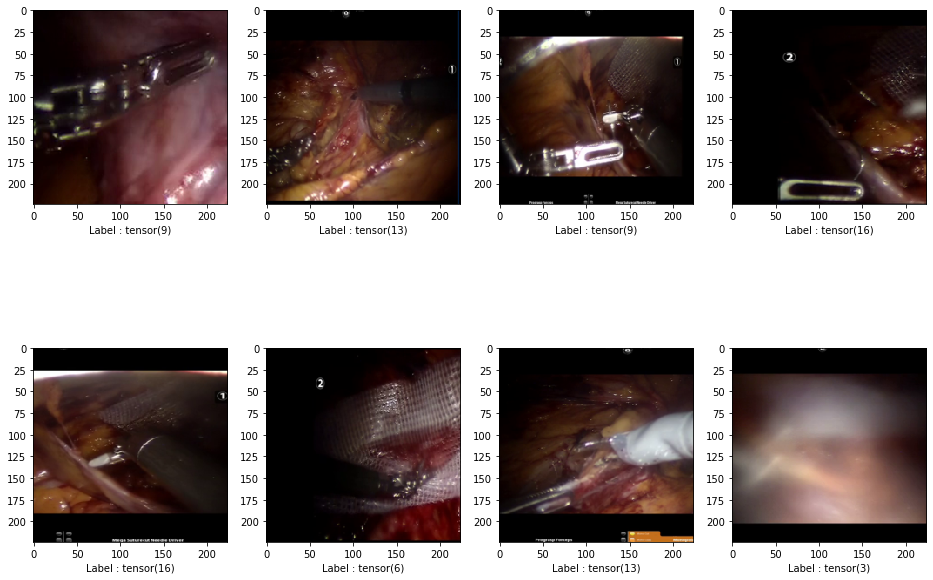

In [88]:
plot(X, y)